In [2]:
import pandas as pd
import numpy as np
import os
os.chdir('/home/kruu/git_folder/eye_tracking/')

from utils.data_processing import EyeTrackingProcessor

import seaborn as sns
import matplotlib.pyplot as plt

****
# Import Data
****

In [24]:
data_path = "/store/kruu/eye_tracking"
files_list = os.listdir(data_path)
files_list = [os.path.join(data_path, file) for file in files_list]

tasks = ['Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6']
features = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y', 'Participant name']
interpolate_col = ['Recording timestamp', 'Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y']

processor = EyeTrackingProcessor()
all_data = processor.load_data(files_list)
dataset = processor.get_features(all_data, tasks, features)

#Fixed size resampling for the whole task
dataset_point_resampled = processor.resample_tasks_fixed_points(dataset, features[:-1], num_points=500)

# Fixed Time step resampling
dataset_time_resampled = processor.resample_tasks_fixed_time(dataset, interpolate_col, timestep = 0.01)

/home/kruu/git_folder/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')
/home/kruu/git_folder/eye_tracking/utils/data_processing.py:14: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, sep='\t')


In [12]:
all_data[0].columns

Index(['Recording timestamp', 'Computer timestamp', 'Sensor', 'Project name',
       'Export date', 'Participant name', 'Recording name', 'Recording date',
       'Recording date UTC', 'Recording start time',
       'Recording start time UTC', 'Recording duration', 'Timeline name',
       'Recording Fixation filter name', 'Recording software version',
       'Recording resolution height', 'Recording resolution width',
       'Recording monitor latency', 'Average calibration accuracy (mm)',
       'Average calibration precision SD (mm)',
       'Average calibration precision RMS (mm)',
       'Average calibration accuracy (degrees)',
       'Average calibration precision SD (degrees)',
       'Average calibration precision RMS (degrees)',
       'Average calibration accuracy (pixels)',
       'Average calibration precision SD (pixels)',
       'Average calibration precision RMS (pixels)',
       'Average validation accuracy (mm)',
       'Average validation precision SD (mm)',
       'A

In [15]:
all_data[0]["Eye movement type"].value_counts()

Eye movement type
Fixation        113822
EyesNotFound     62049
Name: count, dtype: int64

In [19]:
all_data[0]["Event"].value_counts()

Event
MouseEvent                       666
KeyboardEvent                    508
Task 5                             6
Task 5 end                         6
Task 2                             6
Task 4 end                         6
Task 6                             6
Task 1                             6
Task 3                             6
Task 1 end                         6
Task 3 end                         6
Task 4                             6
Task 2 end                         6
Task 6 end                         6
RecordingStart                     1
Eye tracker Calibration start      1
Eye tracker Calibration end        1
ScreenRecordingStart               1
ScreenRecordingEnd                 1
RecordingEnd                       1
Name: count, dtype: int64

https://connect.tobii.com/s/article/understanding-tobii-pro-lab-eye-tracking-metrics?language=en_US#IntervalAndEventMetrics

Metrics with MouseEvent and KeyboardEvent in Event column :
- Number during the task
- Time to first click during the task
- Time from first fixation to a mouse click during the task

Fixation (slow movements). They are precomputed using the I-VT gaze filter. 
Note: with raw data, every valid eye tracking sample is treated as a fixation in the column "Eye movement type". We need to get the pre-processed data !
- Number of fixations during the task
- Time to first fixation
- First fixation location
- Whole fixation: fixation starts and ends within the same area of interest

Saccades (fast movements):
- Number
- Peak velocity
- Amplitude
- Direction: Absolute angle between a straight line from saccade start to end and a straight line from saccade start along the horizontal axis of the screen
- Latency
- First saccade in the target area of interest

Detect blinks in the setting panel?

Not finished to read the webpage...

****
# Base statistics
****

- Moyenne
- Ecart-type
- Min/max

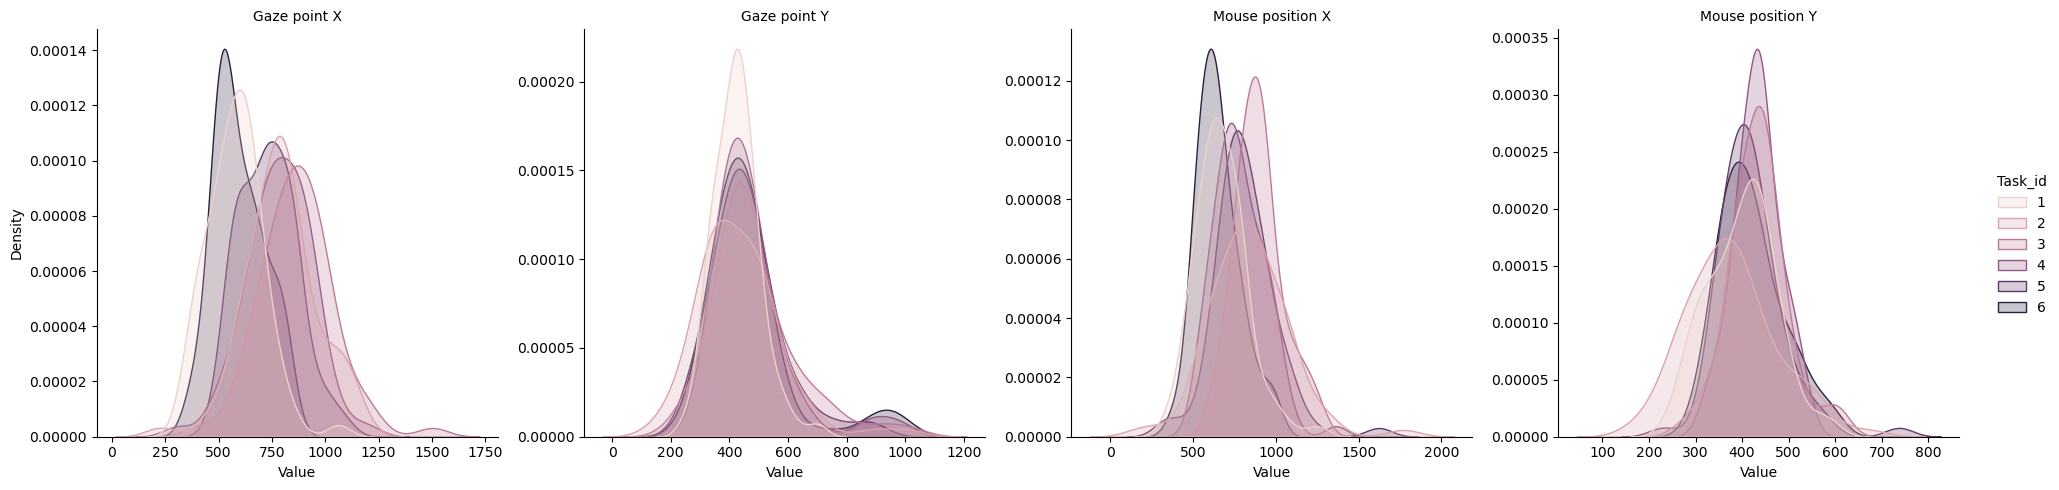

In [3]:
means = dataset.groupby(["Participant name", "Task_id", "Task_execution"])[features[1:-1]].mean().reset_index()

df_melted = means.melt(id_vars=['Participant name', 'Task_id', 'Task_execution'],
                    value_vars=['Gaze point X', 'Gaze point Y', 'Mouse position X', 'Mouse position Y'],
                    var_name='Measurement',
                    value_name='Value')

g = sns.displot(data=df_melted, x='Value', hue='Task_id', col='Measurement', kind='kde', fill=True, facet_kws={'sharex': False, 'sharey': False})
g.set_axis_labels('Value', 'Density')
g.set_titles('{col_name}')
plt.show()

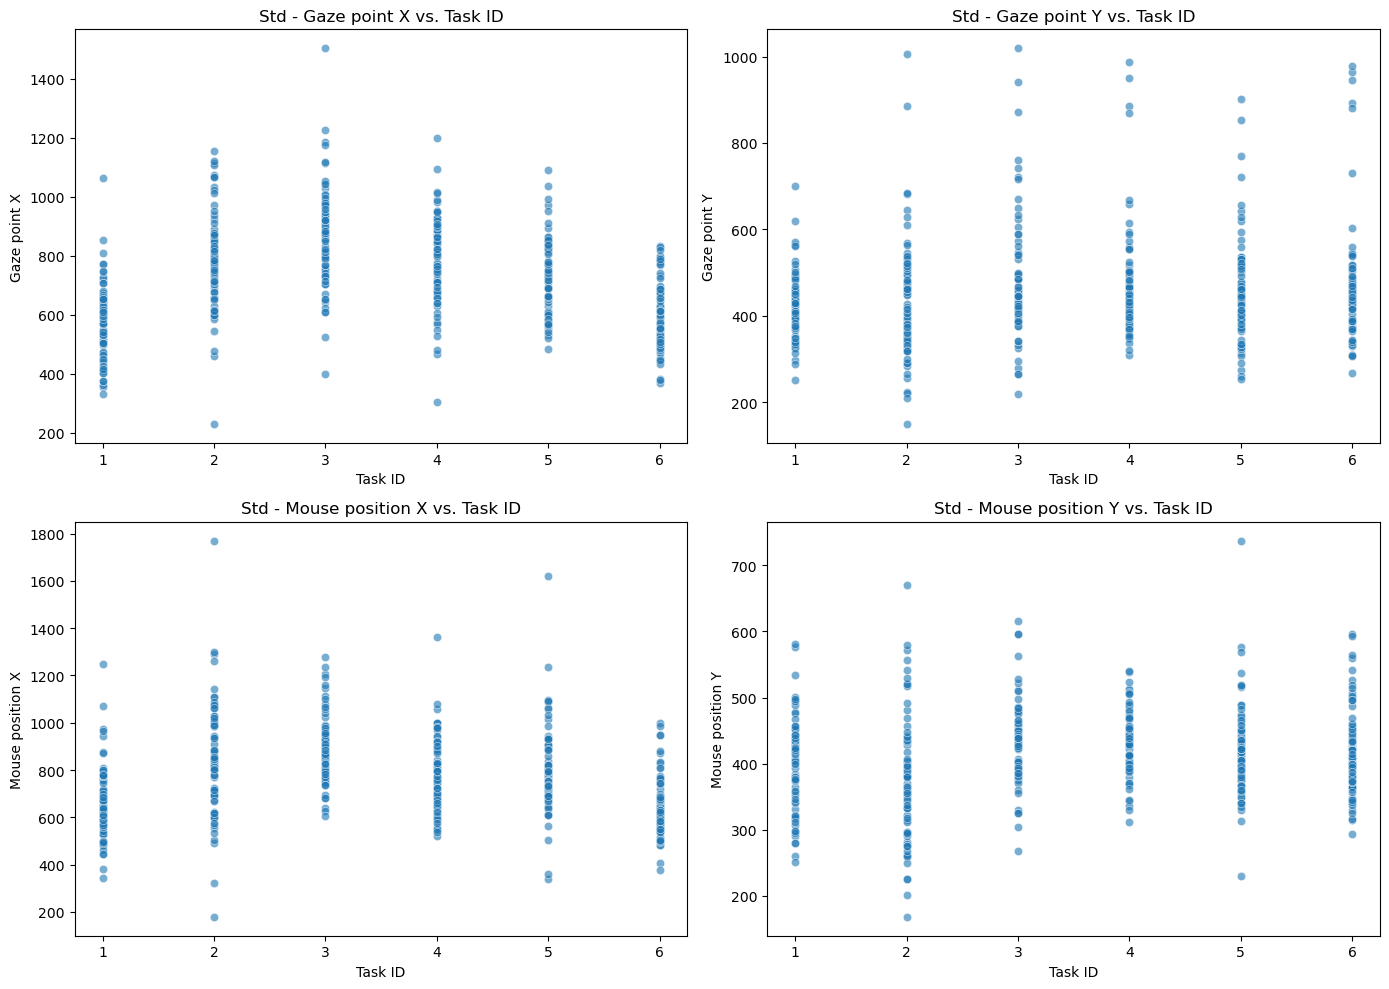

In [ ]:
means = dataset.groupby(["Participant name", "Task_id", "Task_execution"])[features[1:-1]].mean().reset_index()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(features[1:-1]):
    row, col = divmod(i, 2)
    sns.scatterplot(data=means, x="Task_id", y=feature, alpha=0.6, ax=axes[row, col])
    axes[row, col].set_title(f"Mean - {feature} vs. Task ID")
    axes[row, col].set_xlabel("Task ID")
    axes[row, col].set_ylabel(feature)

plt.tight_layout()
plt.show()

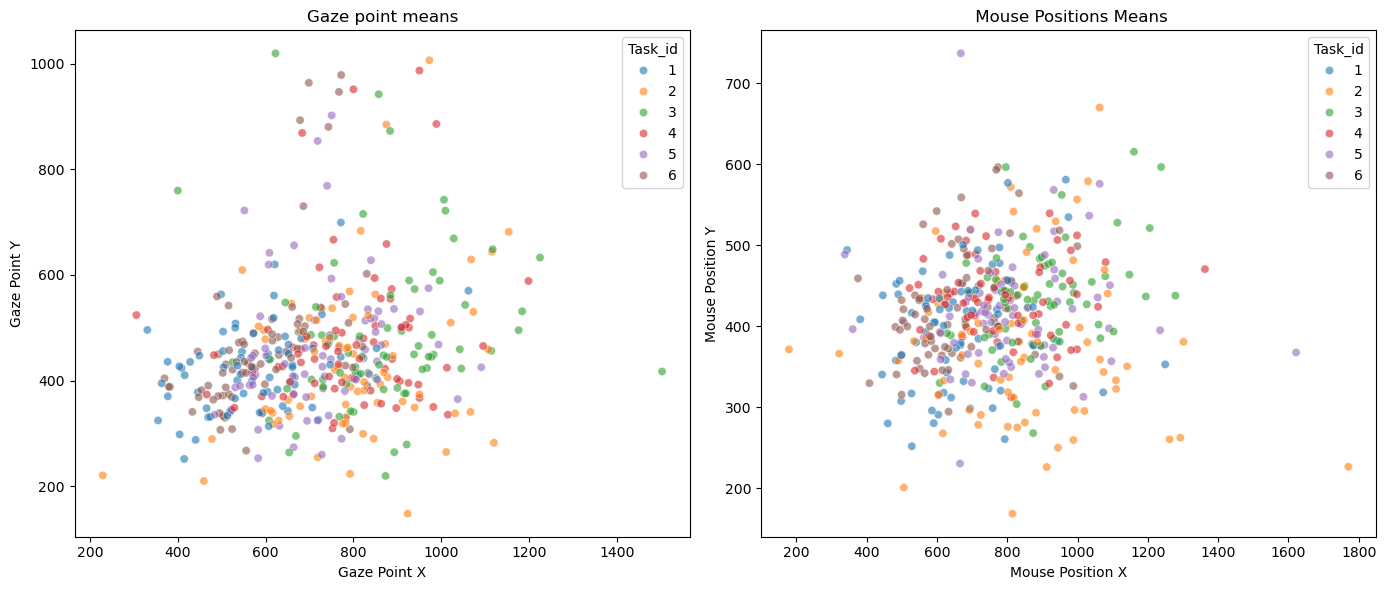

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gaze Points
sns.scatterplot(
    data=means, x="Gaze point X", y="Gaze point Y", hue="Task_id", alpha=0.6, palette="tab10", ax=axes[0]
)
axes[0].set_title("Gaze point means")
axes[0].set_xlabel("Gaze Point X")
axes[0].set_ylabel("Gaze Point Y")

# Mouse Positions
sns.scatterplot(
    data=means, x="Mouse position X", y="Mouse position Y", hue="Task_id", alpha=0.6, palette="tab10", ax=axes[1]
)
axes[1].set_title(" Mouse Positions Means")
axes[1].set_xlabel("Mouse Position X")
axes[1].set_ylabel("Mouse Position Y")

plt.tight_layout()
plt.show()

****
# Blink Identification
****

Blinks cause missing gaze data for short periods (typically 100–300ms), so we can define a blink as a continuous gap in gaze data exceeding a certain duration threshold. 

- Sort the dataset by timestamp (if not already sorted).
- Identify missing gaze points (Gaze point X or Gaze point Y is NaN).
- Compute time gaps between consecutive missing gaze points:
    - If a missing gaze entry is preceded by a valid gaze point, record its timestamp.
    - If a missing gaze entry is followed by a valid gaze point, compute the duration of the gap.
- Mark gaps exceeding a threshold (e.g., 100ms = 100,000 µs) as a blink.

In [25]:
def detect_blinks(df: pd.DataFrame, blink_threshold: int = 1e5)-> pd.DataFrame:
    # Sort by timestamp to ensure proper sequencing
    df = df.sort_values(by=["Participant name", "Task_id", "Task_execution", "Recording timestamp"]).reset_index(drop=True)

    # Identify rows where gaze data is missing
    df["Missing Gaze"] = df["Gaze point X"].isna() | df["Gaze point Y"].isna()

    # Compute time differences between consecutive missing points
    df["Time Diff"] = df["Recording timestamp"].diff()

    # Identify blink start (when missing gaze starts) and blink end (when gaze reappears)
    df["Blink Start"] = df["Missing Gaze"] & ~df["Missing Gaze"].shift(1, fill_value=False)
    df["Blink End"] = ~df["Missing Gaze"] & df["Missing Gaze"].shift(1, fill_value=False)

    # Assign blink IDs
    df["Blink ID"] = df["Blink Start"].cumsum()

    # Compute blink durations
    blink_durations = df.groupby("Blink ID")["Time Diff"].sum().reset_index()

    # Define blink threshold (100ms = 100,000 µs)
    blink_threshold = 100_000  # 100ms

    # Filter blinks that are longer than the threshold
    blinks_detected = blink_durations[blink_durations["Time Diff"] > blink_threshold]

    # Create a binary blink mask column in the original dataframe
    df["Blink"] = df["Blink ID"].isin(blinks_detected["Blink ID"]).astype(int)

    # Drop unnecessary intermediate columns
    df.drop(columns=["Missing Gaze", "Time Diff", "Blink Start", "Blink End", "Blink ID"], inplace=True)
    
    return df, blinks_detected

In [26]:
dataset_blinks, blinks_detected = detect_blinks(dataset)

In [30]:
blinks_detected

,Blink ID,Time Diff
25,26,183326.0
67,68,249990.0
81,82,141656.0
82,83,241663.0
110,111,216655.0
...,...,...
179510,179511,324986.0
179512,179513,299987.0
179522,179523,116665.0
179523,179524,241657.0


****
# Metrics for gaze data
****

A fixation is a group of consecutive gaze points that remain within a spatial radius (e.g. 50 pixels) for more than 100ms:
- Fixation count: Number of fixations in a task execution
- Fixation duration: Average and total duration of fixations
- Fixation dispersion: How spread-out the fixations are in a given task

Saccades are rapid eye movements between fixations:
- Saccade count: number of detected saccades
- Saccade amplitude: Euclidean distance between two consecutive fixations
- Saccade velocity: Speed of saccadic movement
- Saccade frequency: Number of saccades per second

Gaze velocity and acceleration:
- Velocity: euclidean distance per time step
- Acceleration: change in velocity per time step

Blink rate:
- Number of blinks per second

Gaze Dispersion:
- Spread of gaze points within a task execution
- Can be computed using convex hull area or bounding box width/height


In [ ]:
from scipy.spatial import ConvexHull

# Function to compute fixation statistics
def compute_fixations(df, time_threshold=100000, radius_threshold=50):
    """
    Identify fixations based on a spatial threshold (radius) and temporal threshold (min duration).

    Args:
        df: DataFrame containing gaze data for a task execution.
        time_threshold: Minimum duration (in microseconds) for a fixation.
        radius_threshold: Max displacement (in pixels) within a fixation.

    Returns:
        Fixation count, total fixation duration, and dispersion.
    """
    fixations = []
    start_time = None
    fixation_points = []

    for i in range(1, len(df)):
        dist = np.sqrt((df.iloc[i]["Gaze point X"] - df.iloc[i - 1]["Gaze point X"])**2 +
                       (df.iloc[i]["Gaze point Y"] - df.iloc[i - 1]["Gaze point Y"])**2)
        
        if dist <= radius_threshold:
            if start_time is None:
                start_time = df.iloc[i - 1]["Recording timestamp"]
            fixation_points.append((df.iloc[i]["Gaze point X"], df.iloc[i]["Gaze point Y"]))
        else:
            if start_time is not None:
                duration = df.iloc[i - 1]["Recording timestamp"] - start_time
                if duration >= time_threshold:
                    fixations.append((start_time, df.iloc[i - 1]["Recording timestamp"], fixation_points))
                start_time = None
                fixation_points = []

    fixation_count = len(fixations)
    total_fixation_duration = sum(end - start for start, end, _ in fixations) if fixations else 0
    avg_fixation_duration = total_fixation_duration / fixation_count if fixation_count > 0 else 0

    return fixation_count, total_fixation_duration, avg_fixation_duration

# Function to compute saccade statistics
def compute_saccades(df):
    """
    Compute saccade count, amplitude, and velocity.

    Args:
        df: DataFrame containing gaze data for a task execution.

    Returns:
        Saccade count, average amplitude, and average velocity.
    """
    saccade_amplitudes = []
    saccade_velocities = []

    for i in range(1, len(df)):
        time_diff = df.iloc[i]["Recording timestamp"] - df.iloc[i - 1]["Recording timestamp"]
        if time_diff > 0:
            dist = np.sqrt((df.iloc[i]["Gaze point X"] - df.iloc[i - 1]["Gaze point X"])**2 +
                           (df.iloc[i]["Gaze point Y"] - df.iloc[i - 1]["Gaze point Y"])**2)
            saccade_amplitudes.append(dist)
            saccade_velocities.append(dist / (time_diff / 1e6))  # Convert to per second

    saccade_count = len(saccade_amplitudes)
    avg_saccade_amplitude = np.mean(saccade_amplitudes) if saccade_count > 0 else 0
    avg_saccade_velocity = np.mean(saccade_velocities) if saccade_count > 0 else 0

    return saccade_count, avg_saccade_amplitude, avg_saccade_velocity

# Function to compute velocity and acceleration
def compute_velocity_acceleration(df):
    """
    Compute gaze velocity and acceleration.

    Args:
        df: DataFrame containing gaze data for a task execution.

    Returns:
        Average velocity and acceleration.
    """
    velocities = []
    accelerations = []

    for i in range(1, len(df)):
        time_diff = df.iloc[i]["Recording timestamp"] - df.iloc[i - 1]["Recording timestamp"]
        if time_diff > 0:
            dist = np.sqrt((df.iloc[i]["Gaze point X"] - df.iloc[i - 1]["Gaze point X"])**2 +
                           (df.iloc[i]["Gaze point Y"] - df.iloc[i - 1]["Gaze point Y"])**2)
            velocity = dist / (time_diff / 1e6)  # Convert to per second
            velocities.append(velocity)

            if len(velocities) > 1:
                acc = (velocities[-1] - velocities[-2]) / (time_diff / 1e6)
                accelerations.append(acc)

    avg_velocity = np.mean(velocities) if velocities else 0
    avg_acceleration = np.mean(accelerations) if accelerations else 0

    return avg_velocity, avg_acceleration

# Function to compute blink rate
def compute_blink_rate(df):
    """
    Compute blink rate (blinks per second).

    Args:
        df: DataFrame containing blink data for a task execution.

    Returns:
        Blink rate (blinks per second).
    """
    total_time = (df["Recording timestamp"].max() - df["Recording timestamp"].min()) / 1e6  # Convert to seconds
    blink_count = df["Blink"].sum()
    blink_rate = blink_count / total_time if total_time > 0 else 0

    return blink_rate

# Function to compute gaze dispersion
def compute_gaze_dispersion(df):
    """
    Compute gaze dispersion using convex hull.

    Args:
        df: DataFrame containing gaze data for a task execution.

    Returns:
        Convex hull area representing gaze dispersion.
    """
    points = df[["Gaze point X", "Gaze point Y"]].dropna().to_numpy()
    if len(points) < 3:
        return 0  # Convex hull requires at least 3 points

    hull = ConvexHull(points)
    return hull.area

# Compute all features per task execution
task_stats = []

# Iterate over each unique task execution
for (participant, task, execution), group in df.groupby(["Participant name", "Task_id", "Task_execution"]):
    fixation_count, total_fix_duration, avg_fix_duration = compute_fixations(group)
    saccade_count, avg_saccade_amp, avg_saccade_vel = compute_saccades(group)
    avg_velocity, avg_acceleration = compute_velocity_acceleration(group)
    blink_rate = compute_blink_rate(group)
    gaze_dispersion = compute_gaze_dispersion(group)

    task_stats.append({
        "Participant": participant,
        "Task_id": task,
        "Task_execution": execution,
        "Fixation Count": fixation_count,
        "Total Fixation Duration (ms)": total_fix_duration / 1e3,  # Convert to milliseconds
        "Avg Fixation Duration (ms)": avg_fix_duration / 1e3,
        "Saccade Count": saccade_count,
        "Avg Saccade Amplitude": avg_saccade_amp,
        "Avg Saccade Velocity (px/s)": avg_saccade_vel,
        "Avg Gaze Velocity (px/s)": avg_velocity,
        "Avg Gaze Acceleration (px/s²)": avg_acceleration,
        "Blink Rate (blinks/s)": blink_rate,
        "Gaze Dispersion (area)": gaze_dispersion
    })

# Convert to DataFrame and display
task_stats_df = pd.DataFrame(task_stats)


In [31]:
def compute_fixation_statistics(df, time_threshold=100000, radius_threshold=50):
    """Compute fixation count, total duration, and average duration with a time constraint."""
    dx = df["Gaze point X"].diff().fillna(0)
    dy = df["Gaze point Y"].diff().fillna(0)
    displacement = np.sqrt(dx**2 + dy**2)

    # Identify fixations where gaze stays within a radius and meets the minimum time threshold
    fixation_mask = displacement < radius_threshold
    fixation_start_time = df["Recording timestamp"].where(fixation_mask & ~fixation_mask.shift(1, fill_value=False))
    fixation_end_time = df["Recording timestamp"].where(~fixation_mask & fixation_mask.shift(1, fill_value=False))

    # Drop NaNs and compute fixation durations
    fixation_start_time = fixation_start_time.dropna().to_numpy()
    fixation_end_time = fixation_end_time.dropna().to_numpy()

    # Ensure same length (some fixations may not have proper end times)
    min_len = min(len(fixation_start_time), len(fixation_end_time))
    fixation_durations = (fixation_end_time[:min_len] - fixation_start_time[:min_len])  # In microseconds

    # Filter fixations by time threshold
    valid_fixations = fixation_durations >= time_threshold
    fixation_count = valid_fixations.sum()
    total_fixation_duration = fixation_durations[valid_fixations].sum() / 1e6  # Convert to seconds
    avg_fixation_duration = total_fixation_duration / fixation_count if fixation_count > 0 else 0

    return fixation_count, total_fixation_duration, avg_fixation_duration


def compute_saccade_statistics(df, radius_threshold=50):
    """Compute saccade count, amplitude, and velocity."""
    dx = df["Gaze point X"].diff().fillna(0)
    dy = df["Gaze point Y"].diff().fillna(0)
    displacement = np.sqrt(dx**2 + dy**2)
    time_diff = df["Recording timestamp"].diff().fillna(0) / 1e6  # Convert to seconds

    saccade_mask = displacement >= radius_threshold
    saccade_count = saccade_mask.sum()
    avg_saccade_amplitude = displacement[saccade_mask].mean() if saccade_count > 0 else 0
    avg_saccade_velocity = (displacement[saccade_mask] / time_diff.replace(0, np.nan)).mean() if saccade_count > 0 else 0

    return saccade_count, avg_saccade_amplitude, avg_saccade_velocity


def compute_velocity_acceleration(df):
    """Compute gaze velocity and acceleration."""
    dx = df["Gaze point X"].diff().fillna(0)
    dy = df["Gaze point Y"].diff().fillna(0)
    displacement = np.sqrt(dx**2 + dy**2)
    time_diff = df["Recording timestamp"].diff().fillna(0) / 1e6  # Convert to seconds

    velocity = displacement / time_diff.replace(0, np.nan)
    acceleration = velocity.diff().fillna(0) / time_diff.replace(0, np.nan)

    avg_velocity = velocity.mean()
    avg_acceleration = acceleration.mean()

    return avg_velocity, avg_acceleration


def compute_blink_rate(df):
    """Compute blink rate (blinks per second)."""
    total_time = (df["Recording timestamp"].max() - df["Recording timestamp"].min()) / 1e6  # Convert to seconds
    blink_count = df["Blink"].sum()
    blink_rate = blink_count / total_time if total_time > 0 else 0
    return blink_rate


def compute_gaze_dispersion(df):
    """Compute gaze dispersion using bounding box area."""
    if len(df) > 3:
        gaze_dispersion = (df["Gaze point X"].max() - df["Gaze point X"].min()) * \
                          (df["Gaze point Y"].max() - df["Gaze point Y"].min())
    else:
        gaze_dispersion = 0
    return gaze_dispersion

In [32]:
# Process each task execution
task_stats = []
task_groups = dataset_blinks.groupby(["Participant name", "Task_id", "Task_execution"])

for (participant, task, execution), group in task_groups:
    group = group.sort_values("Recording timestamp").reset_index(drop=True)

    fixation_count, total_fix_duration, avg_fix_duration = compute_fixation_statistics(group)
    saccade_count, avg_saccade_amp, avg_saccade_vel = compute_saccade_statistics(group)
    avg_velocity, avg_acceleration = compute_velocity_acceleration(group)
    blink_rate = compute_blink_rate(group)
    gaze_dispersion = compute_gaze_dispersion(group)

    task_stats.append({
        "Participant": participant,
        "Task_id": task,
        "Task_execution": execution,
        "Fixation Count": fixation_count,
        "Total Fixation Duration (s)": total_fix_duration,
        "Avg Fixation Duration (s)": avg_fix_duration,
        "Saccade Count": saccade_count,
        "Avg Saccade Amplitude (px)": avg_saccade_amp,
        "Avg Saccade Velocity (px/s)": avg_saccade_vel,
        "Avg Gaze Velocity (px/s)": avg_velocity,
        "Avg Gaze Acceleration (px/s²)": avg_acceleration,
        "Blink Rate (blinks/s)": blink_rate,
        "Gaze Dispersion (area)": gaze_dispersion
    })

# Convert to DataFrame and display
task_stats_df = pd.DataFrame(task_stats)

In [33]:
task_stats_df

,Participant,Task_id,Task_execution,Fixation Count,Total Fixation Duration (s),Avg Fixation Duration (s),Saccade Count,Avg Saccade Amplitude (px),Avg Saccade Velocity (px/s),Avg Gaze Velocity (px/s),Avg Gaze Acceleration (px/s²),Blink Rate (blinks/s),Gaze Dispersion (area)
0,1,1,0,93,40.086875,0.431042,231,103.049638,12366.232112,1359.204036,-3.146688e+05,61.231617,2497274.0
1,1,1,1,79,38.277849,0.484530,186,110.553014,13266.732067,1189.181156,-5.261467e+05,65.551351,2179215.0
2,1,1,2,34,18.263099,0.537150,91,107.918363,12950.119623,1173.048448,-4.964325e+05,58.446144,2092032.0
3,1,1,3,65,28.945684,0.445318,181,125.606026,15073.280699,1355.232403,-4.924064e+05,51.037136,2457450.0
4,1,1,4,29,14.927228,0.514732,72,133.694191,16043.817954,1187.204254,-2.909483e+05,66.325614,2304477.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,12,6,1,25,13.833416,0.553337,50,110.232644,13228.276354,1049.551932,-2.369470e+06,58.519525,2341880.0
428,12,6,2,0,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000e+00,120.280255,NaN
429,12,6,3,30,14.030935,0.467698,51,107.021427,12842.962903,980.776157,-2.926941e+05,52.672961,2010843.0
430,12,6,4,29,9.461871,0.326271,103,98.606762,11833.102596,1690.113419,-4.216501e+05,64.397342,2946984.0


/tmp/ipykernel_1484511/3193329718.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=task_stats_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1484511/3193329718.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=task_stats_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1484511/3193329718.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Task_id", y=metric, data=task_stats_df, ax=axes[i], palette="Set2")
/tmp/ipykernel_1484511/3193329718.py:27: FutureWarning: 

Passing `palett

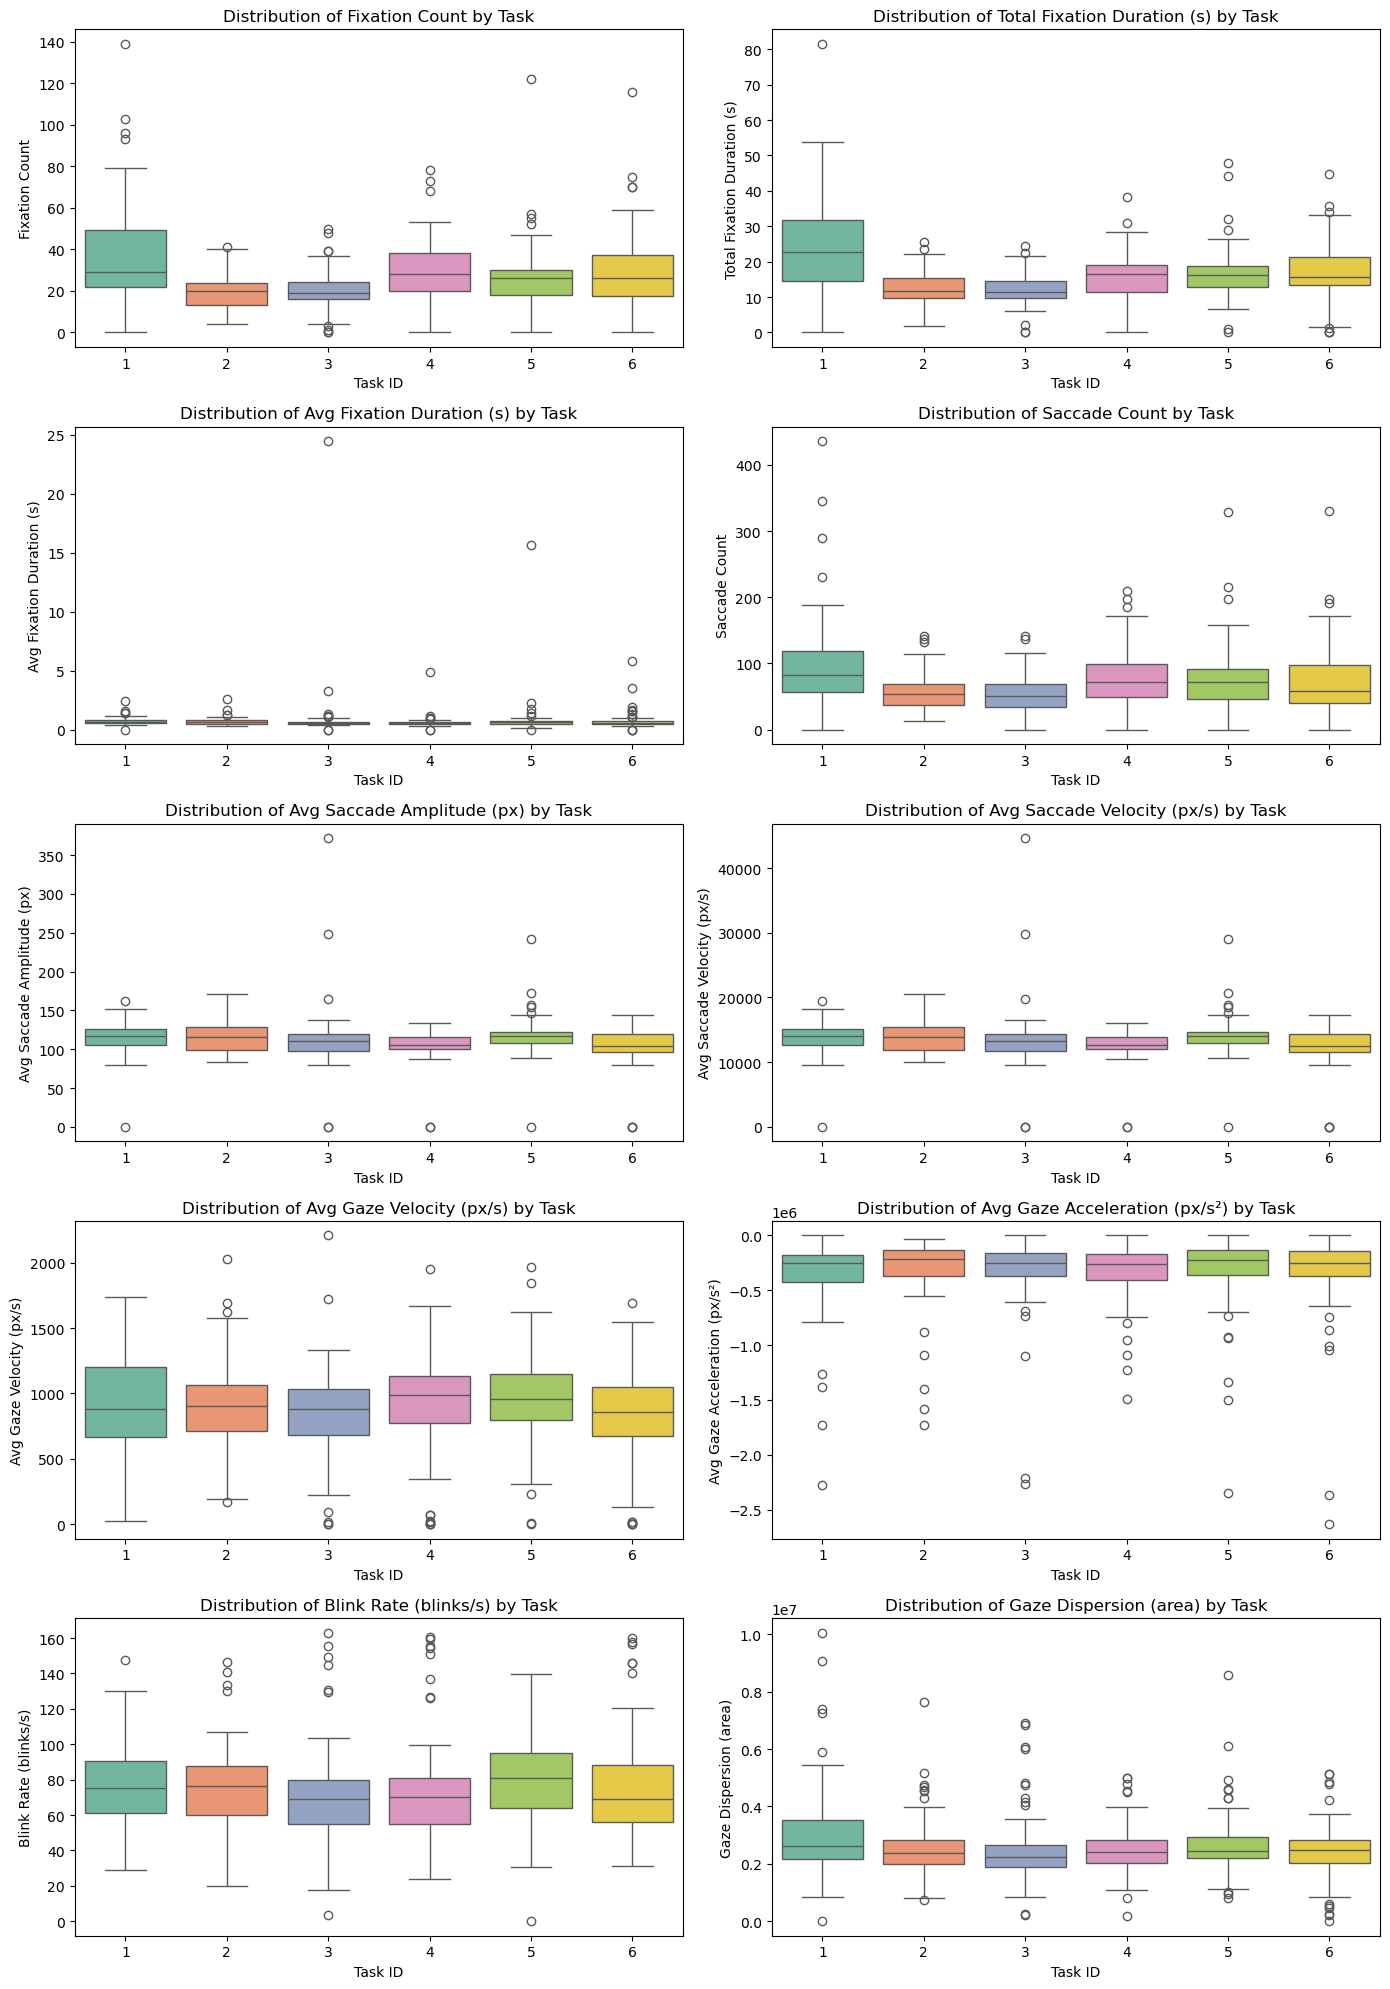

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics to plot
metrics = [
    "Fixation Count",
    "Total Fixation Duration (s)",
    "Avg Fixation Duration (s)",
    "Saccade Count",
    "Avg Saccade Amplitude (px)",
    "Avg Saccade Velocity (px/s)",
    "Avg Gaze Velocity (px/s)",
    "Avg Gaze Acceleration (px/s²)",
    "Blink Rate (blinks/s)",
    "Gaze Dispersion (area)"
]

# Create a grid of subplots
num_metrics = len(metrics)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each metric distribution grouped by Task_id
for i, metric in enumerate(metrics):
    sns.boxplot(x="Task_id", y=metric, data=task_stats_df, ax=axes[i], palette="Set2")
    axes[i].set_title(f"Distribution of {metric} by Task")
    axes[i].set_xlabel("Task ID")
    axes[i].set_ylabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()
